# CTDBackup Markdown

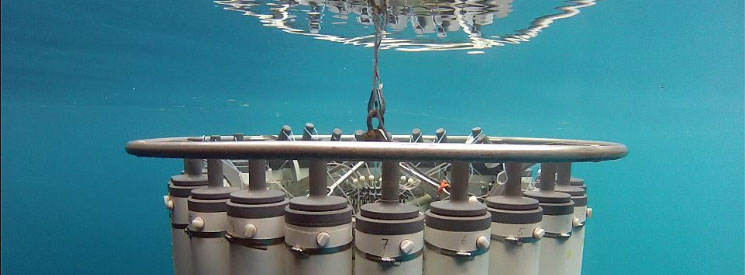

This guide will help you troubleshoot and understand the CTDBackup program. The code has been complied into a stand alone program but if the program needs to be changed you can use this Markdown to make changes and test code before compiling.

Import packages you will need to run the code

In [16]:
import PySimpleGUI as sg
import pandas as pd
from datetime import datetime
# import ReadCTDFiles as rf
from zipfile import ZipFile
import configparser as cp
import os
from shutil import copy2
import errno
import glob
import sys
from collections import Counter
import string

Specify the specific config file and its location. You can the location of this ctdconfig here: T:\Marina_testing\For Renae\ctdconfig.ini

In [17]:
# Select the configurations needed for testing or when out at sea
cfg = 'SHIP' # Specifies which configuration to read from config file.  You can have one for the ship and one or more for testing.

You will need to change this path to where the ctdconfig.ini file is saved on the computer. Or uncomment/comment the below path that you are working from Q is server at sea T is server on land

In [18]:
#cfile = r'Q:\Marina_testing\For Renae\ctdconfig.ini' # Config file to fill in default values

In [19]:
cfile = r'T:\Marina_testing\For Renae\ctdconfig.ini' # Config file to fill in default values

Ship Directory to look up the ship on the cruise. If CalCOFI sails on a different vessel not on this list the list will need to be update.

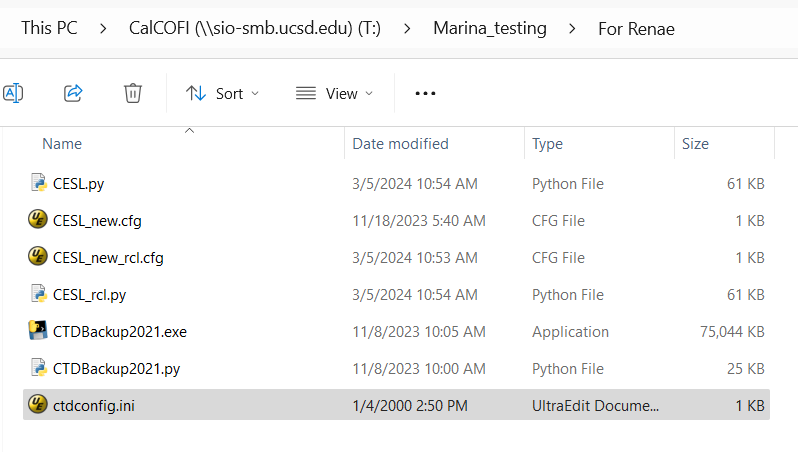

In [20]:
ship_dict={
    'DAVID STARR JORDAN': 'JD',
    'SALLY RIDE': 'SR',
    'BOLD HORIZON': 'BH',
    'ROGER REVELLE': 'RR',
    'SPROUL': 'SP',
    'SHIMADA': 'SH',
    'OCEANUS': 'OC',
    'LASKER': 'RL'
}

# Adding defined FUNCTIONS to use within the code

Convert latitude and longitude to decimal values

In [21]:
def convertCoords(ll):
    llarr=ll.split(" ")
    decll=f"{(int(llarr[0])+float(llarr[1])/60.0):.6f}"
    return decll

## CESL

Takes information from the header (hdr) and marker (mrk) file and adds the information to the CESL log

In [22]:
def writeLog(hdr_dict, mrk_df, cesl_fname):
    foutput = cesl_fname
    
    # If file already exists, remove it, otherwise we'll end up appending stuff to existing file.
    if os.path.exists(foutput):
        os.remove(foutput)
    with open(foutput, 'a') as f:
        linest = hdr_dict['Station'].split(" ") # split so we can put a comma between line and station
        shipcode=ship_dict.get(hdr_dict['Ship'], 'Invalid ship name') # If invalid, edit shi_dict above to add the correct name
        hdr1 = hdr_dict['Cruise'][0:-2]+','+f"{int(hdr_dict['Cast'])}"+','+f"{linest[0]},{linest[1]}"+',,,'+hdr_dict['NMEA_UTC_FMT']+','+hdr_dict['declat']+','+hdr_dict['declon']+',CTD,FROM PYTHON,'+hdr_dict['Operator']+',,,,0\n'
        f.write(hdr1)
        hdr2 = ' 0, '+hdr_dict['System_UTC']+','+hdr_dict['Latitude']+','+hdr_dict['Longitude']+f",{hdr_dict['System_UTC']},"+hdr_dict['Ship']+f',{shipcode},'+hdr_dict['Cruise']+','+hdr_dict['Station']+','+hdr_dict['Cast']+','+hdr_dict['Operator']+','+hdr_dict['Cast_type']+',,,,,,,,,,,,\n'
        f.write(hdr2)
        #Iterate over rows of the mrk dataframe
        for index, md in mrk_df.iterrows():
            line = f"{index+1:>2}, {md['timestamp']} ,,,{md['depSM'].strip()},{md['t090C'].strip()},{md['sal00'].strip()},{md['sigma-é00'].strip()},,,,{md['sbeox0ML/L'].strip()},{md['v0'].strip()},{md['v1'].strip()},{md['v2'].strip()},,,,,,,,,\n"
            f.write(line)

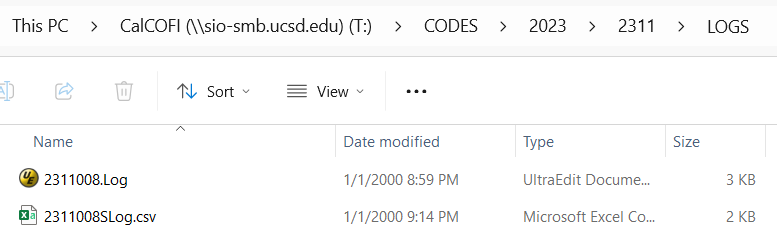

Takes information from the header (hdr), marker (mrk) file and the information from the CESL log and addes it to the Saved CESL Log that is updated during sampling.

In [23]:
def writeSLog(hdr_dict, mrk_df, slog_fname, prd={}):
    # To be read in by CESL
    foutput = slog_fname
    # If file already exists, remove it, otherwise we'll end up appending stuff to existing file.
    if os.path.exists(foutput):
        os.remove(foutput)
    with open(foutput, 'a') as f:
        linest = hdr_dict['Station'].split(" ") # split so we can put a comma between line and station
        hdr1=f"{hdr_dict['Cast'].zfill(4)},{hdr_dict['Cast']}, CalCOFI {hdr_dict['Cruise'][0:-2]},{hdr_dict['Ship']},,{hdr_dict['Nav_date_FMT']},{hdr_dict['declat']},{hdr_dict['declon']},{linest[0]},{linest[1]},{hdr_dict['Cast_type']},,,,,,,,,,,,,\n"
        f.write(hdr1)
        f.write("Nisk,Sample,Depth,Temp,Salt,Flask,O2 T,Salt,Nuts,Chl,Phyto,Prodo,DIC/pH,NCOG,JOSI,TOC,Size,Comments,Niskin,Depth,FCM,Pico,Nano,Micro,HPLC,POM,TOC,Size,Phyto,Prodo,Comments\n")
        #Iterate over rows of the mrk dataframe
        for index, md in mrk_df.iterrows():
            istr=str(index+1).zfill(2)
            if(str(index+1) in prd ):           #prodo bottle
                prodo = prd[str(index+1)]
            else:
                prodo=''            
            if float(md['depSM']) > 200:
                line=f"{istr},{istr},{float(md['depSM']):.1f},{md['t090C'].strip()},{md['sal00'].strip()},,{istr},{istr},,,,{prodo},,,,,,,{istr},{float(md['depSM']):.1f},,,,,,,,,,,\n"
            else:
                line=f"{istr},{istr},{float(md['depSM']):.1f},{md['t090C'].strip()},{md['sal00'].strip()},,{istr},{istr},{istr},,,{prodo},,,,,,,{istr},{float(md['depSM']):.1f},,,,,,,,,,,\n"
            f.write(line)

Reads the PRODO bottles information and adds this information to CESL Log

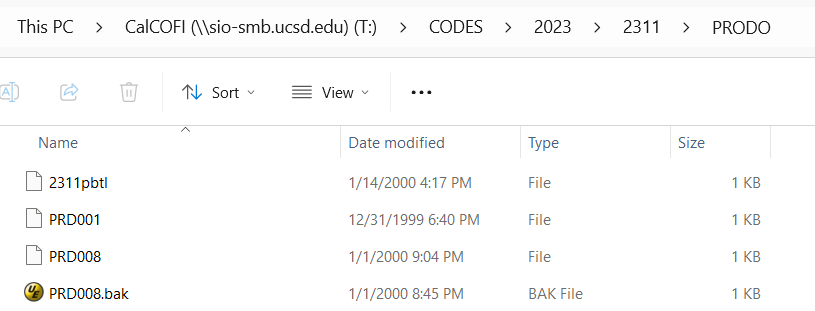

In [24]:
def readProdosFile(fname):
    # Only done for prodo casts
    prodos=[]
    with open(fname, 'r') as f:
        for line in f:
            prodos.append(line.strip())
    # Discard first two line
    prodos=prodos[2:]
    # Get Count for each bottle number
    cdict=dict(Counter(prodos))
    # Create dict and return it
    prodos_bls={}
    for k in cdict:
        prodos_bls[k] = k+string.ascii_lowercase[0:cdict[k]]
    return prodos_bls

## Nav File

Gathers data from the Header (hdr) and transforms the data (lats/lons) and puts the information in the Navigation (nav) files.

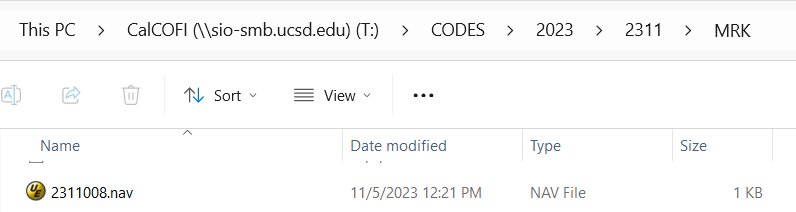

In [25]:
def readHdrFileAndNav(fname, navname) :
    # Collect info from .hdr and .nav files
    hdr_dict = {}
    with open(fname, 'r') as f:
        for line in f:
            uline = line.upper()
            if "UPLOAD" in uline:
                hdr_dict['UploadTime'] = line.split("=")[1].strip()
                continue
            if "NMEA UTC" in uline:
                hdr_dict['NMEA_UTC'] = line.split("=")[1].strip()
                hdr_dict['NMEA_UTC_FMT'] = datetime.strptime(hdr_dict['NMEA_UTC'], '%b %d %Y %H:%M:%S').strftime('%m/%d/%Y %I:%M %p') # reformat date as MM/DD/YYYY
                continue
            if "SYSTEM UTC" in uline:
                hdr_dict['System_UTC'] = line.split("=")[1].strip()
                hdr_dict['System_UTC_FMT'] = datetime.strptime(hdr_dict['System_UTC'], '%b %d %Y %H:%M:%S').strftime('%m/%d/%Y %I:%M %p') # reformat date as MM/DD/YYYY
                continue
            if "NMEA LATITUDE" in uline:
                hdr_dict['Latitude'] = line.split("=")[1].strip()
                continue
            # Might not need these long and lat, we're overwriting them from nav file anyway
            if "NMEA LONGITUDE" in uline: 
                hdr_dict['Longitude'] = line.split("=")[1].strip()
                continue
            if "SHIP" in uline:
                hdr_dict['Ship'] = line.split(":")[1].strip()
                continue
            if "CRUISE" in uline:
                hdr_dict['Cruise'] = line.split(":")[1].strip()
                continue
            if "STATION" in uline:
                hdr_dict['Station'] = line.split(":")[1].strip()
                continue
            if "CAST:" in uline:
                hdr_dict['Cast'] = line.split(":")[1].strip()
                continue
            if "OPERATOR" in uline:
                hdr_dict['Operator'] = line.split(":")[1].strip()
                continue
            if "TYPE" in uline:
                hdr_dict['Cast_type'] = line.split(":")[1].strip()
                continue

    with open(navname, 'r') as fn:
        for line in fn: 
            if 'C:' in line:
                continue
            else:
                linearr = line.split(',')
                hdr_dict['Nav_date']=linearr[0].strip()
                hdr_dict['Nav_date_FMT']=datetime.strptime(hdr_dict['Nav_date'], '%b %d %Y %H:%M:%S').strftime('%m/%d/%Y,%I:%M %p') # reformat date as MM/DD/YYYY
                hdr_dict['Latitude']=linearr[1].strip()
                hdr_dict['Longitude']=linearr[2].strip()
                break
    # Get decimal values for lat/lon
    hdr_dict['declat'] = convertCoords(hdr_dict['Latitude'])
    hdr_dict['declon'] = convertCoords(hdr_dict['Longitude'])
    return hdr_dict

## Marker File

Collects data from the marker (mrk) file.

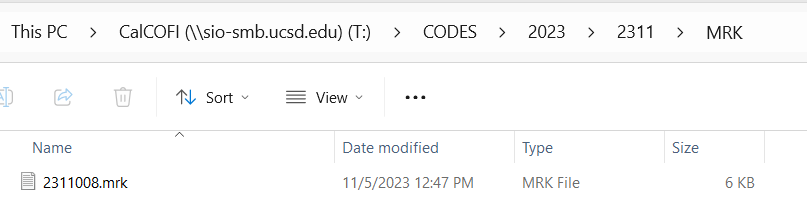

In [26]:
def readMarkFile(fname):
    # Collect data from .mrk file
    # This file alternates between lines of data and lines of mark info, from which we only need the datettime stamp.
    mrk_array = []
    data_array = []
    lnum=1
    with open(fname, 'r') as f:
        for line in f:
            if line[0:4] == 'mark':
                mrk_array.append(line.split("is")[1].strip())
            else:
                if lnum ==2:
                    headers=line # Column headers
                else:
                    if lnum > 3:
                        data_array.append(line.strip())
            lnum += 1

    # convert data_array (which is an array of strings) to a dataframe for easier access
    df = pd.DataFrame([sub.split(",") for sub in data_array])

    df.columns = [cn.strip() for cn in headers.split(",")] # add column names to dataframe
    df['timestamp'] = mrk_array
    return df

## GUI interface with User

Creating the pop-up GUI that the user interacts with.

In [27]:
def MergeFilesForPrint(path, cruise, cast, dest_file):
    # Merge .hdr, .nav and .bl files in path for a given cruise and cast into a single .prn file
    # First, check if dest_file already exists; if yes, ask if user wants to overwrite
    if os.path.exists(dest_file):
        ow = sg.popup_yes_no(f'{dest_file} already exists! Overwrite?')
        print(f'User clicked {ow}')
        if ow == 'No':
            return 1
    # Check if input files exist
    hdr_file = os.path.join(path, f"{cruise}{cast}.hdr")
    if os.path.exists(hdr_file) == False:
        raise FileNotFoundError(errno.ENOENT, f"Can't find {hdr_file}")
    nav_file = os.path.join(path, f"{cruise}{cast}.nav")
    if os.path.exists(hdr_file) == False:
        raise FileNotFoundError(errno.ENOENT, f"Can't find {nav_file}")
    bl_file = os.path.join(path, f"{cruise}{cast}.bl")
    if os.path.exists(hdr_file) == False:
        raise FileNotFoundError(errno.ENOENT, f"Can't find {bl_file}")
    filenames = [hdr_file, bl_file, nav_file]
    try:
        with open(dest_file, 'w') as outfile:
            for fname in filenames:
                with open(fname, 'r', encoding='utf8', errors='replace') as infile:
                    for line in infile:
                        if not line.startswith('#'): #skip comments
                            outfile.write(line)
    except PermissionError as err:
        sg.popup_ok(f"You don't have permission to access these files!", line_width=90, button_color="red", title='Error')
    except Exception as err:
        sg.popup_ok(err, line_width=90, button_color="red",
                    title='Error')
    else:
        return 0

GUI that creates or updates the configuration file. The inputs are a dictionary of values from the GUI screen. cfg is the configuration name ('SHIP' for shipboard configuration, else developer-specific)

In [28]:
def WriteConfigFile(cfg, inputs, pop=True):
    config = cp.ConfigParser()
    config.read(cfile)
    if config.has_section(cfg):  # replacing existing section
        for opt in inputs:
            config.set(cfg, opt, inputs[opt])
    else:  # adding new section
        config.add_section(cfg)
        for opt in inputs:
            config.set(cfg, opt, inputs[opt])
    # save configuration
    with open(cfile, 'w') as CF:
        config.write(CF)

    if pop:
        sg.popup_ok('Successfully wrote config file',
                cfile,
                line_width=90
                )
    return 0

## Saving CTD in various places for redundancy and safety net if overwritten accidently

Copy CTD files to network drive

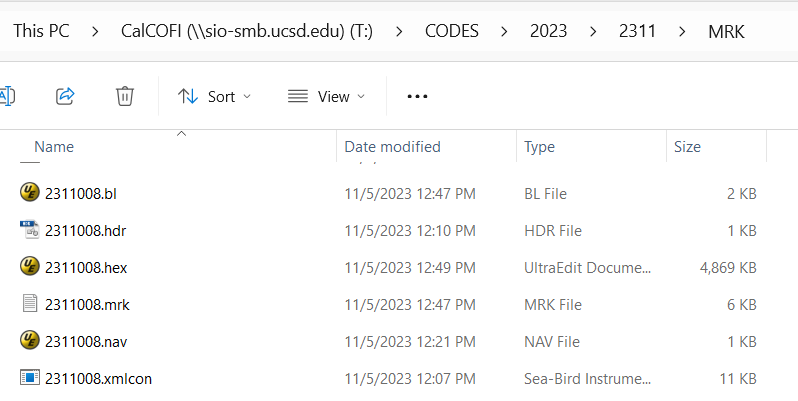

In [29]:
def CopyFilesToQ(path, npath, cruise, cast):
    mrkdir = os.path.join(npath, 'Mrk')  # destination directory
    if not os.path.isdir(mrkdir):
        print(f"Cannot find {mrkdir}, using {npath} as destination directory")
        mrkdir = npath
    copyfiles = {}
    copyfiles['blfname'] = f"{cruise}{cast}.bl"
    copyfiles['navfname'] = f"{cruise}{cast}.nav"
    copyfiles['hdrfname'] = f"{cruise}{cast}.hdr"
    copyfiles['mrkfname'] = f"{cruise}{cast}.mrk"
    copyfiles['xmlfname'] = f"{cruise}{cast}.xmlcon"
    copyfiles['hexfname'] = f"{cruise}{cast}.hex"

    ret = 0
    for fname in copyfiles:
        src = os.path.join(path, copyfiles[fname])
        try:
            copy2(src, mrkdir)
        except Exception as err:
            print(f"{err} copying file {src} to {mrkdir}")
            ret = 1
            continue
    return ret

Copy of the CTD Zipped to destination folders. Example:
ctdpath = C:\Users\marin\Documents\Python\Cruise\Cruise\2107\CTD\Mrk
flashpath = C:\Users\marin\Documents\Python\CTDBackup-files\CTDBackup\Flash
cruisepath = C:\Users\marin\Documents\Python\Cruise\Cruise\output\2107
zippath = C:\Users\marin\Documents\Python\CTDBackup-files\CTDBackup\TEMP

In [30]:
def ZipTheFiles(path, flist, dest_file):
    # Zip all the files in flist to dest_file
    # path is the directory where the source files are
    count = 0
    if len(flist) == 0:
        raise FileNotFoundError(errno.ENOENT, 'CTD files not found. Check path settings and try again.')
    with ZipFile(dest_file, 'w') as zip:
        for filename in flist:
            fpath = os.path.join(path, filename)
            try:
                zip.write(fpath)
            except Exception as e:
                success = False
                sg.popup_ok(e, line_width=90, button_color="red", title='Error')
            else:
                success = True
                count += 1
    return success, count

Pop-up GUI that user can manually enter in the information if the configuration file was not updated.

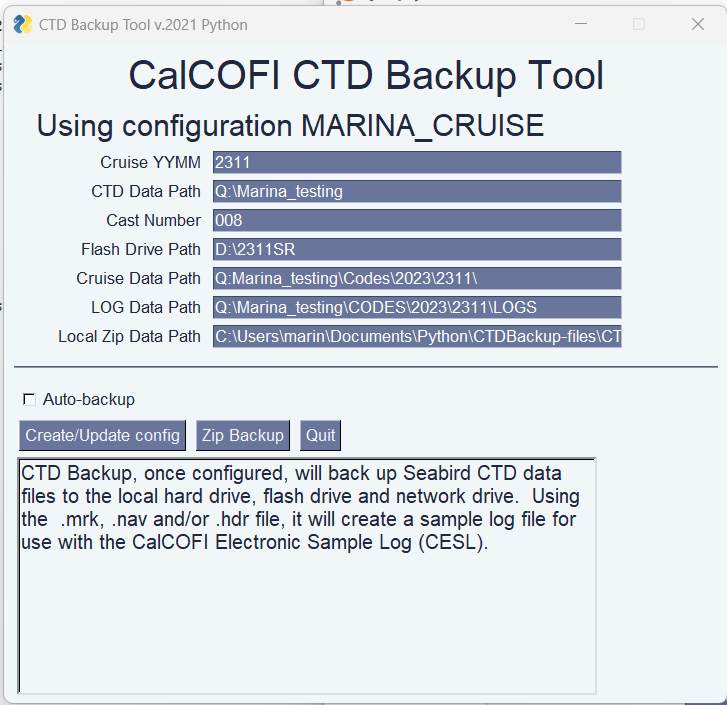

In [31]:
LABEL_SIZE = 20
config = cp.ConfigParser()
if not os.path.exists(cfile):
    sg.popup_ok(f'Missing config file {cfile} ', line_width=90, button_color="red", title='Error')
try:
    config.read(cfile) # Get default setting from the config file
except Exception as e:
    sg.popup_ok('Problem reading config file ',e, line_width=90, button_color="red", title='Error')

sg.theme('light blue 6')  # Add a touch of color
# All the stuff inside your window.
try:
    layout = [
          [sg.Text('CalCOFI CTD Backup Tool', justification="center", font=("bold", 24), size=30)],
          [sg.Text(f'Using configuration {cfg}', justification="center", font=("bold", 18), size=30)],
          [sg.Text('Cruise YYMM', tooltip="CalCOFI cruise designation (ie 2107), NO SHIP CODE",
                   size=LABEL_SIZE, justification='right'),
                   sg.Input(default_text=config[cfg]['CruiseYYMM'], key='Cruise')],
          [sg.Text('CTD Data Path',
                   size=LABEL_SIZE,
                   justification='right',
                   tooltip="Local CTD Data Directory, usually C:\\YYMMSS or C:\\YYMM\\ no ship code"),
                    sg.InputText(default_text=config[cfg]['CTDPath'].zfill(3), key='CTDPath')],
          [sg.Text('Cast Number',
                   size=LABEL_SIZE,
                   justification='right',
                   tooltip="Processing Number aka Order Occupied"),
                   sg.InputText(default_text=config[cfg]['CastNumber'], key='CastNum')],
          [sg.Text('Flash Drive Path',
                   size=LABEL_SIZE,
                   justification='right',
                   tooltip="Local Zip Backup location, in case Q: is not connected"),
                   sg.InputText(default_text=config[cfg]['FlashPath'], key='FlashPath')
                   #sg.Checkbox(default=True, text='On', key='FlashOn')
           ],
          [sg.Text('Cruise Data Path',
                   size=LABEL_SIZE,
                   justification='right',
                   tooltip="Cruise base data path(Q:\\CODES\\YYYY\\YYMM\\) but can be local -- this where unzipped files will be copied, adding 'CTD' to path"),
                   sg.InputText(default_text=config[cfg]['CruisePath'], key='CruisePath')],
                   #sg.Checkbox(default=True, text='On', key='CruiseOn')],
          [sg.Text('LOG Data Path',
                   size=LABEL_SIZE,
                   justification='right',
                   tooltip="Cruise base data path(Q:\\CODES\\YYYY\\YYMM\\) but can be local -- this where CESL log files will go, adding 'LOGS' to path"),
                   sg.InputText(default_text=config[cfg]['logpath'], key='LogPath')],
          [sg.Text('Local Zip Data Path',
                   size=LABEL_SIZE,
                   justification='right',
                   tooltip="Local data path for cruise Zip file, usually C:\\TEMP\\"),
                   sg.InputText(default_text=config[cfg]['ZipPath'], key='ZipPath')],
                   #sg.Checkbox(default=True, text='On', key='ZipOn')],
          [sg.HorizontalSeparator(p=(0, 15))],
          [sg.Checkbox(default=False, text='Auto-backup',
                       tooltip="Click this to set up automatic backup, otherwise click [Zip Backup] to archive",
                       key='auto')],
          [sg.Button('Create/Update config', tooltip="Save values from this screen to config file"),
           sg.Button('Zip Backup', tooltip="Edit the cast number to the value you want, then click this button to continue"),
           # sg.Button('Batch Backup', tooltip="Back up all the casts, with a separate zip file for each cast"),
           sg.Button('Quit')],
          [sg.Text('CTD Backup, once configured, will back up Seabird CTD data files to the local hard drive, flash drive and network drive.  Using the  .mrk, .nav and/or .hdr file, it will create a sample log file for use with the CalCOFI Electronic Sample Log (CESL).',
                   relief='sunken', border_width=3, font='bold', pad=3, size=(52, 10))]
          ]
except Exception as e:
    sg.popup_ok('Problem creating GUI ',e, 'Please check config file settings.', line_width=90, button_color="red", title='Error')



Backs up the data to the various and send information to the various log files and data files. Will also return an Error message if cannot save, or a success message and a warning message to TURN OFF DECK UNIT.

In [32]:
def doBackup(CTDPath, Cruise, CastNum, file_path, out_path, log_path, slog_path, net_path, prodo_path, isgui):
    try:
        filelist = glob.glob(file_path) # Get list of all files in file_path
    except Exception as e:
        sg.popup_ok(e, line_width=90, button_color="red", title='Error')
    else:
        goodsave=False
        try:
            caststr=CastNum.zfill(3)
            [fret, fnum] = ZipTheFiles(file_path, filelist, out_path)  # zip to flash drive
            [fret1, fnum1] = ZipTheFiles(file_path, filelist, local_path)  # zip to local disk
            ret1 = CopyFilesToQ(CTDPath, net_path, Cruise, caststr)
            if ret1 == 1:
                sg.popup_ok('There was a problem copying files to the network drive',
                            net_path,
                            'Please check settings and try again',
                            line_width=90, button_color="red", title='Warning')
            try: 
                mfile = os.path.join(CTDPath,f"{Cruise}{caststr}.mrk")
                mrk_df = readMarkFile(mfile)
            except Exception as e:
                sg.popup_ok(f'Error reading mark file at {mfile}', e, line_width=90, button_color="red", title='Error')
                return goodsave
            try:
                hfile=os.path.join(CTDPath,f"{Cruise}{caststr}.hdr")
                nfile=os.path.join(CTDPath, f"{Cruise}{caststr}.nav")
                hdr = readHdrFileAndNav(hfile, nfile)
            except Exception as e:
                sg.popup_ok(f'Error reading hdr or nav file in  {CTDPath}', e, line_width=90, button_color="red", title='Error')
                return goodsave
            if os.path.exists(prodo_path):
                prd=readProdosFile(prodo_path)
            else:
                prd={}
            try:
                writeLog(hdr, mrk_df, log_path)
                writeSLog(hdr,mrk_df, slog_path, prd)
            except Exception as e:
                sg.popup_ok(f"Couldn't write log files to {CTDPath}",e, line_width=90, button_color="red", title='Error')
                return goodsave

        except Exception as e:
            sg.popup_ok(e, line_width=90, button_color="red", title='Error')
        else:
            CastNum = str(int(CastNum)+1).zfill(3)  # increment cast number
            inputs['castnumber'] = CastNum
            if isgui: window['CastNum'].update(CastNum)
            WriteConfigFile(cfg, inputs, False)  # update config file with new cast number
            goodsave=True
    
    if goodsave:
        ret = sg.popup_ok(f'Successfully zipped {fnum} CTD files.',
                        # '.hdr .nav and .bl merged into .prn file',
                        f'Backup: {local_path}',
                        f'Flash drive: {out_path}',
                        # f'Print File: {prn_path}',
                        f'CESL Log: {slog_path}' ,
                        'Please turn off the Seabird Deck Unit and unplug the ISUS NO3 battery.',
                        font='Helvetica 18 italic bold',
                        background_color='light yellow',
                        title='Success!',
                        line_width=90)
    return goodsave

Section creates the GUI and collects the user's inputs to create an loop to process "events" and get the "values" of the inputs

In [33]:
if __name__ == "__main__":
    # If auto flag not set in config file and -g option not given, create the GUI
    flag = sys.argv[1] if len(sys.argv) > 1 else '-a'
    if config[cfg]['auto'] == 'NO' or flag.lower() == '-g':
        # Create GUI and collect the inputs
        window = sg.Window('CTD Backup Tool v.2021 Python', layout)
        # Event Loop to process "events" and get the "values" of the inputs

        while True:
            event, values = window.read()
            Cruise = values['Cruise']
            CastNum = values['CastNum'].zfill(3)
            CTDPath = values['CTDPath']
            FlashPath = values['FlashPath']
            CruisePath = values['CruisePath']
            LogPath = values['LogPath']
            ZipPath = values['ZipPath']
            Auto = 'YES' if values['auto'] else 'NO'

            inputs = {
                'cruiseyymm': Cruise,
                'castnumber': CastNum,
                'ctdpath': CTDPath,
                'flashpath': FlashPath,
                'cruisepath': CruisePath,
                'logpath': LogPath,
                'zippath': ZipPath,
                'firstbottle': config[cfg]['firstbottle'] if 'firstbottle' in config[cfg] else 'DEEP',
                'auto': Auto
            }

            if event == sg.WIN_CLOSED or event == 'Quit':  # if user closes window or clicks quit
                break
            elif event == 'Create/Update config':
                try:
                    cfgret = WriteConfigFile(cfg, inputs)
                except Exception as e:
                    sg.popup_ok('Error writing config file ', e, line_width=90, button_color="red", title='Error')
            else:
                file_path = os.path.join(CTDPath, f"{Cruise}{CastNum.zfill(3)}*.*")
                out_path = os.path.join(FlashPath, f'{CastNum.zfill(3)}.zip')  # flash drive
                #prn_path = os.path.join(CruisePath, f"{Cruise}{CastNum.zfill(3)}.prn")  # print file
                log_path = os.path.join(LogPath,f"{Cruise}{CastNum.zfill(3)}.csv") # Log file
                slog_path= os.path.join(LogPath,f"{Cruise}{CastNum.zfill(3)}Log.csv")# SLog file (For CESL)
                net_path = os.path.join(CruisePath,'CTD')  # network drive where unzipped files get copied
                prodo_path = os.path.join(CruisePath, 'PRODO', f'PRD{CastNum.zfill(3)}') # prodo file to look for
                local_path = os.path.join(ZipPath, f'{CastNum.zfill(3)}.zip')  # local dir
                print('The Origin Path is  ', file_path)
                print('The destination path for .zip file is ', out_path)
                # print('The destination path for .prn file is ', prn_path) Don't need this file anymore
                print('The destination for the log file is ', log_path)
                print('The destination fo SLog file is ', slog_path)
                # Create the prn file, it will be zipped with all the other files
#               try:
#                     res=MergeFilesForPrint(CTDPath, Cruise, CastNum.zfill(3), prn_path)
#                 except Exception as e:
#                     sg.popup_ok(e, line_width=90, button_color="red", title='Error')
#                     continue
#                 else:
#                     if res == 1:
#                         continue 
                try:
                    filelist = glob.glob(file_path) # Get list of all files in file_path
                except Exception as e:
                    sg.popup_ok(e, line_width=90, button_color="red", title='Error')
                else:
                    doBackup(CTDPath, Cruise, CastNum, file_path, out_path, log_path, slog_path, net_path, prodo_path, True)
        window.close()
    else:
        # Use values from config file

        print('Running automatic CTD Backup...')
        print(f'Configuration {cfg} from config file {cfile}')
        try:
            CTDPath = config[cfg]['ctdpath']
            Cruise = config[cfg]['cruiseyymm']
            CastNum = config[cfg]['castnumber']
            FlashPath = config[cfg]['flashpath']
            CruisePath = config[cfg]['cruisepath']
            ZipPath = config[cfg]['zippath']
            Auto = config[cfg]['auto']
        except Exception as e:
            sg.popup_ok('Check config file settings', e, line_width=90, button_color="red", title='Error')
            

        inputs = {
            'cruiseyymm': Cruise,
            'castnumber': CastNum,
            'ctdpath': CTDPath,
            'flashpath': FlashPath,
            'cruisepath': CruisePath,
            'zippath': ZipPath,
            'firstbottle': config[cfg]['firstbottle'] if 'firstbottle' in config[cfg] else 'DEEP',
            'auto': Auto
        }

        file_path = os.path.join(CTDPath, f"{Cruise}{CastNum.zfill(3)}*.*")
        out_path = os.path.join(FlashPath, f'{CastNum.zfill(3)}.zip')  # flash drive
        #prn_path = os.path.join(CTDPath, f"{Cruise}{CastNum.zfill(3)}.prn")  # print file
        net_path = os.path.join(CruisePath, 'CTD')  # network drive where unzipped files get copied
        prodo_path = os.path.join(CruisePath, 'PRODO', f'PRD{CastNum.zfill(3)}') # prodo file to look for
        print(f'PRODO FILE IS {prodo_path}')
        log_path = os.path.join(CruisePath, f"{Cruise}{CastNum.zfill(3)}.csv") # Log file
        slog_path= os.path.join(CruisePath, f"{Cruise}{CastNum.zfill(3)}Log.csv") # SLog file (For CESL)
        local_path = os.path.join(ZipPath, f'{CastNum.zfill(3)}.zip')  # local dir
        #print('Merging hdr, nav and bl files for printing...')
        #res = MergeFilesForPrint(CTDPath, Cruise, CastNum.zfill(3), prn_path)
        doBackup(CTDPath, Cruise, CastNum, file_path, out_path, log_path, slog_path, net_path, prodo_path, False)
        sys.exit(0)


AttributeError: 'NoneType' object has no attribute 'zfill'

There should be a GUI pop-up that now displays, if not then you will get a warning to explain what the issue is.